# zone by zone analysis

In [ ]:
from IPython.display import HTML

HTML('''<script>
  jQuery(document).ready(function($) {

  $(window).load(function(){
    $('#preloader').fadeOut('slow',function(){$(this).remove();});
  });

  });
</script>

<style type="text/css">
  div#preloader { position: fixed;
      left: 0;
      top: 0;
      z-index: 999;
      width: 100%;
      height: 100%;
      overflow: visible;
      background: #fff url('http://preloaders.net/preloaders/720/Moving%20line.gif') no-repeat center center;
  }

</style>

<div id="preloader"></div>''')

In [1]:
from IPython.display import HTML

HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')

In [10]:
# this set up the  interactive visualisation mode for graphics.
#%matplotlib notebook 
%matplotlib inline
import pandas as pd
import numpy as np
pd.set_option('display.max_rows',7) #only visualise 7 rows when displaying tables
from vega import vegalite
import vega
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage import feature
from skimage import measure
from ipywidgets import interact, interactive, fixed
from copy import deepcopy
from skimage import data, img_as_float
from skimage import exposure
from operator import itemgetter
from itertools import groupby

# Deploying the strategy 

In [16]:
def analyse(im):
    
    im  = im[:,:,0]
    im = im[0:655, 0:1024]
    im = exposure.equalize_adapthist(im, clip_limit=0.03)
    edges = feature.canny(im,sigma=1.5)
    dup_edges=deepcopy(edges)
    
    update_edges,ranges = clustered(dup_edges)
    
    res = np.sum(update_edges,axis=0)/2
    res = res[0:-1] ## remove the last value wich is always 0 by the algo
    res[0] = res[1]
    s = pd.Series(res)
    r = s.rolling(window=50,center=True,min_periods=3).mean()
    df = pd.DataFrame({'Analyse':s, 'Moyenne glissante':r})
    
    return {'im': im, 'edges':edges,'new_edges':update_edges, 'df':df}


def plot_analysis(im, edges,new_edges,r, width=10):
    fig, (ax1, ax2, ax3,ax4) = plt.subplots(nrows=1, ncols=4, sharex=True, sharey=False, figsize=(width, 4))
    ax1.imshow(im,cmap=plt.cm.gray)
    ax2.imshow(edges,cmap=plt.cm.gray)
    ax3.imshow(new_edges,cmap=plt.cm.gray)
    r.plot(ax=ax4)
    ymax=max(r)
    xmax=r.idxmax(axis=0, skipna=True)
    
    ax1.set_title('Image originale')
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    
    ax2.set_title('Edges')
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    
    ax3.set_title('Cleaned Edges')
    ax3.set_xlabel('x')
    ax3.set_ylabel('y')
    
    ax4.set_ylim(0,ymax+25)
    ax4.set_title('Number of Striations')
    ax4.set_xlabel('x')
    ax4.set_ylabel('nb de stries [-]')
    ax4.annotate('Max:', xy=(xmax, ymax), xytext=(xmax, ymax+10),
             arrowprops=dict(facecolor='black', shrink=0.05),
            )
    
    return fig

def clustered(edge):
    
    for k in range(edge.shape[1]):
   
        ranges = []
        j, = np.where(edge[:,k]==True)
        data=j
        for key, group in groupby(enumerate(data), lambda i: i[0] - i[1]):
            group = list(map(itemgetter(1), group))
            if len(group)>1:
            
                edge[group[1]:group[-1]+1,k]=False
            
            ranges.append(group)
    
    return edge,ranges

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from skimage import data, img_as_float
from skimage import exposure


matplotlib.rcParams['font.size'] = 8


def plot_img_and_hist(image, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram.

    """
    image = img_as_float(image)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(image, cmap=plt.cm.gray)
    ax_img.set_axis_off()
    ax_img.set_adjustable('box-forced')

    # Display histogram
    ax_hist.hist(image.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf

def img_preprocess(img):
    # Load an example image
    #tiff_file = "samples/CET0127527_024.tif"

    #img = plt.imread(tiff_file)
    img  = img[:,:,0]
    img = img[0:655, 0:1024]

    # Contrast stretching
    p2, p98 = np.percentile(img, (2, 98))
    img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))

    # Equalization
    img_eq = exposure.equalize_hist(img)

    # Adaptive Equalization
    img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)

    # Display results
    fig = plt.figure(figsize=(8, 5))
    axes = np.zeros((2, 4), dtype=np.object)
    axes[0, 0] = fig.add_subplot(2, 4, 1)
    for i in range(1, 4):
        axes[0, i] = fig.add_subplot(2, 4, 1+i, sharex=axes[0,0], sharey=axes[0,0])
    for i in range(0, 4):
        axes[1, i] = fig.add_subplot(2, 4, 5+i)

    ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])
    ax_img.set_title('Low contrast image')

    y_min, y_max = ax_hist.get_ylim()
    ax_hist.set_ylabel('Number of pixels')
    ax_hist.set_yticks(np.linspace(0, y_max, 5))

    ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_rescale, axes[:, 1])
    ax_img.set_title('Contrast stretching')

    ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_eq, axes[:, 2])
    ax_img.set_title('Histogram equalization')

    ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_adapteq, axes[:, 3])
    ax_img.set_title('Adaptive equalization')

    ax_cdf.set_ylabel('Fraction of total intensity')
    ax_cdf.set_yticks(np.linspace(0, 1, 5))

    # prevent overlap of y-axis labels
    fig.tight_layout()
    plt.show()
    

def browse_samples(images):
    n = len(images)
    def view_image(i):
        fig =plot_analysis(res[i]['im'],res[i]['edges'],res[i]['new_edges'],res[i]['df']['Moyenne glissante'],width=12)
        
    interact(view_image, i=(0,n-1))

def browse_histograms(images):
    n = len(images)
    def view_histogram(i):
        img_preprocess(images[i]) 
        
    interact(view_histogram, i=(0,n-1))

PREPROCESSING OF IMAGES
- ADAPTIVE HISTOGRAM

/Users/NSN/anaconda3/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint16
  "%s to %s" % (dtypeobj_in, dtypeobj))


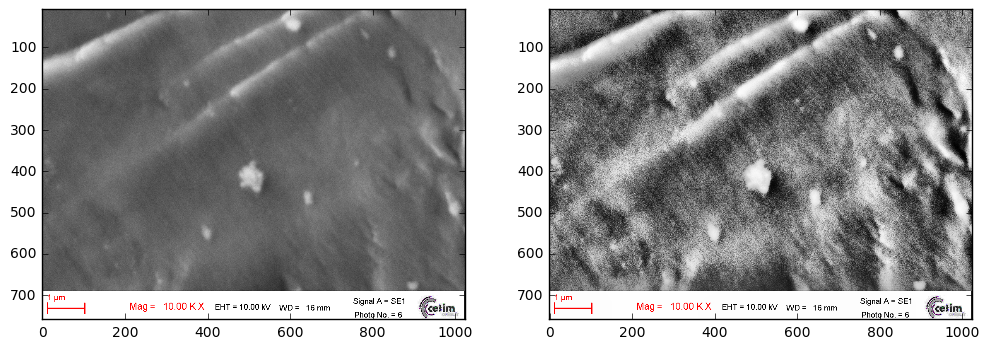

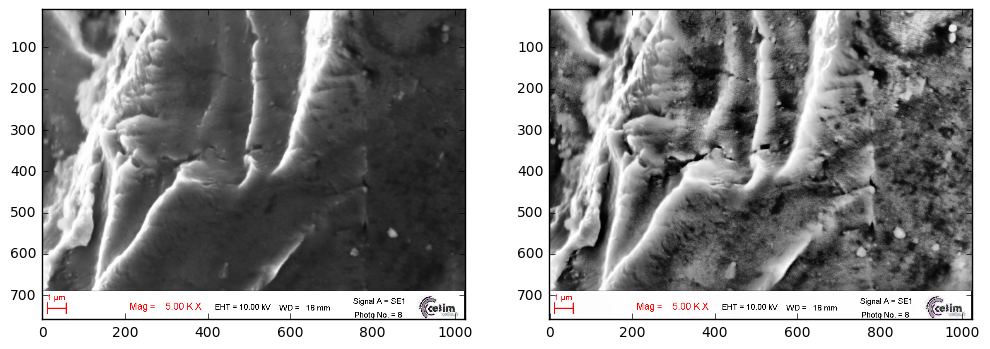

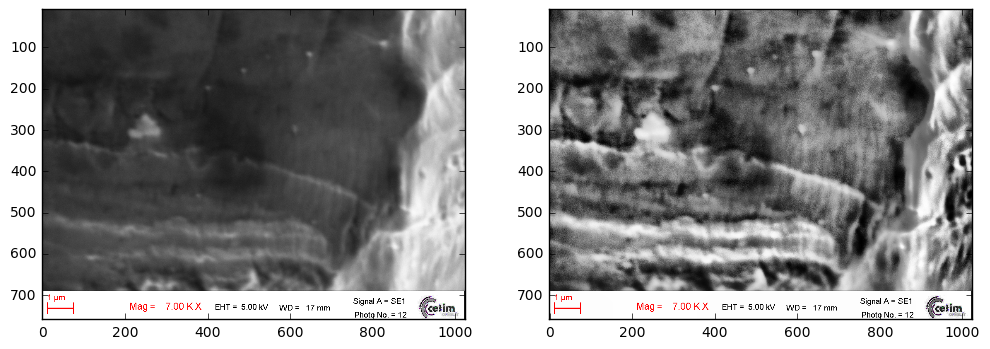

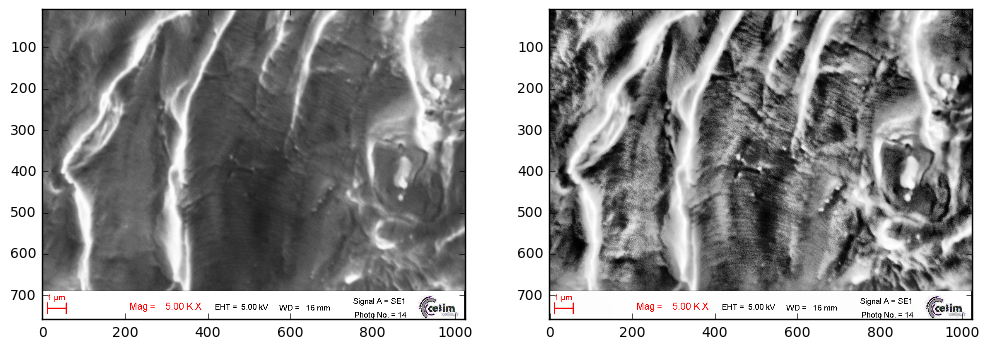

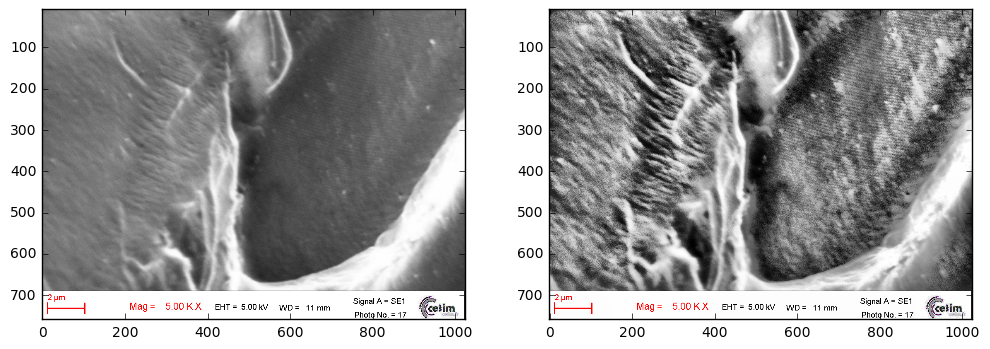

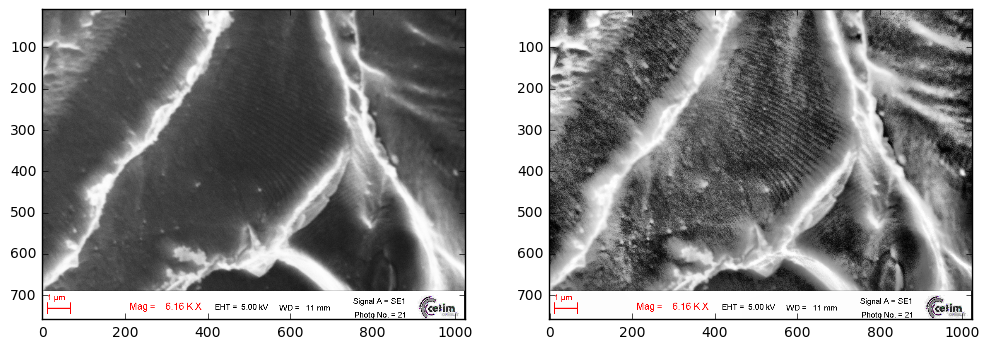

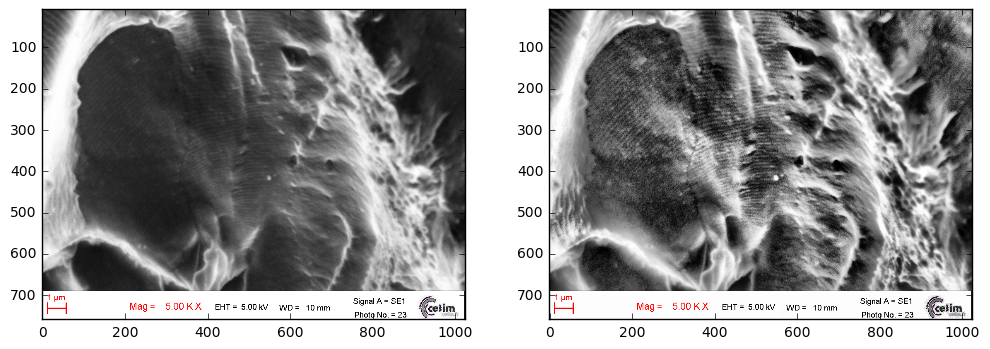

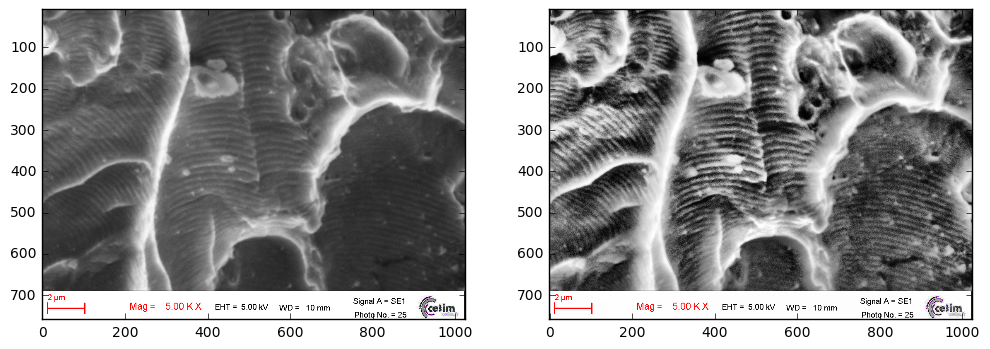

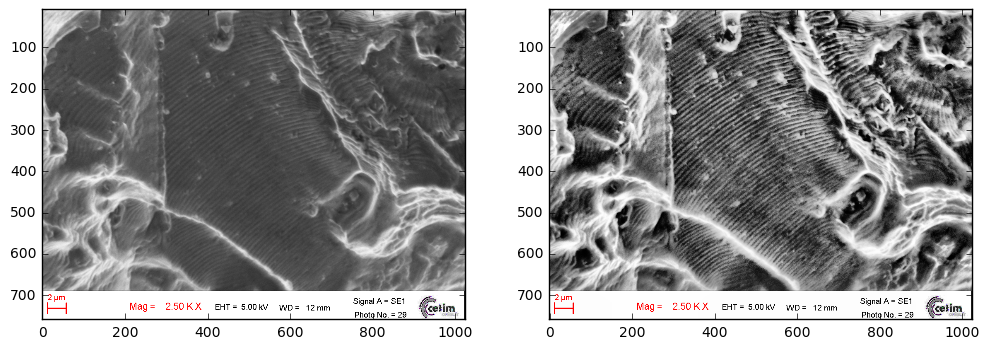

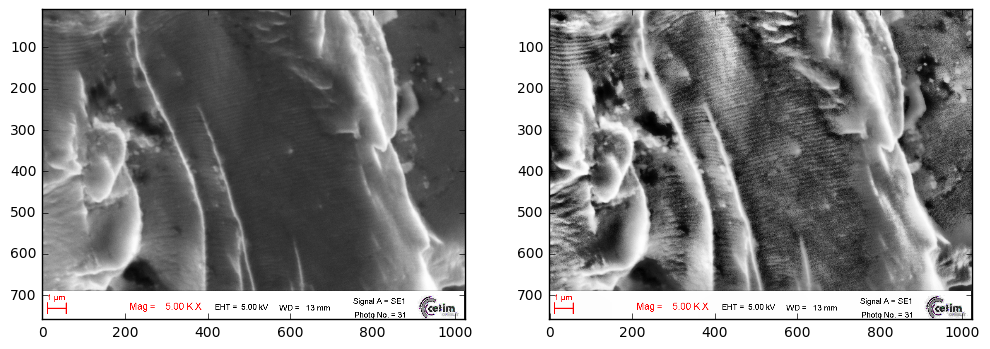

In [13]:
from PIL import Image
import glob
image_list = []
for filename in glob.glob('samples/*.tif'):
    im=plt.imread(filename)
    image_list.append(im)

for image in image_list:
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=False, figsize=(12, 4))
    ax1.imshow(image,cmap=plt.cm.gray)
    img_adapteq = exposure.equalize_adapthist(image, clip_limit=0.03)
    ax2.imshow(img_adapteq,cmap=plt.cm.gray)
    
  


In [18]:
res = [ analyse(x) for x in image_list]

nb_stries=[max(res[i]['df']['Moyenne glissante']) for i in range(10)]

In [ ]:
browse_histograms(image_list)

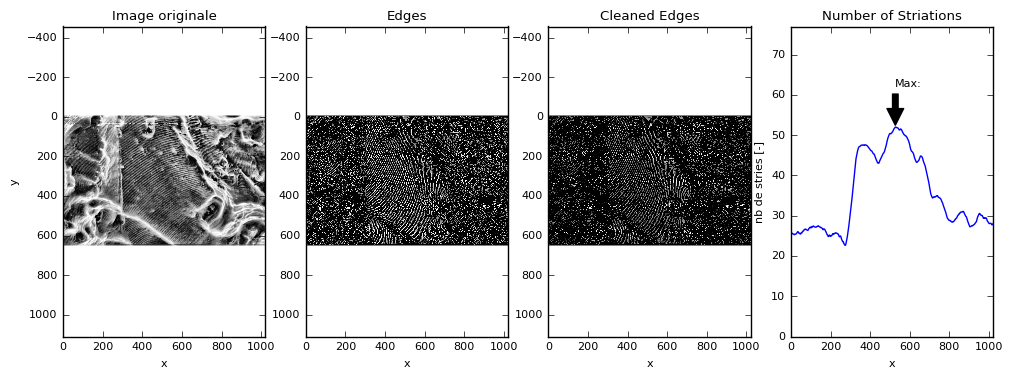

In [19]:
browse_samples(image_list)

In [20]:
calibration=[11.29,24.64,24.64,24.64,22.58,24.64,24.64,22.58,49.27,24.64]
calibration=[calibration[i]/1024*655 for i in range(10)]

zone=[0,3.4,6,9,12,15,18,21,24,27,30,30.1]
delta=[(zone[i+1]-zone[i])*1000 for i in range(len(zone)-1)]
delta.insert(0,zone[0])

In [21]:
i=[calibration[j]/nb_stries[j] for j in range(len(nb_stries))]

In [22]:
i.insert(0,i[0])
i.insert(len(i),i[-1])

i_moy=[(i[j]+i[j-1])/2 for j in range(1,len(i)) ]
i_moy.insert(0,i[0])

In [23]:
stries=[delta[i]/i_moy[i] for i in range(len(delta))]

In [24]:
tabular=pd.DataFrame({'Position':zone,'i':i,'delta':delta,'i moy':i_moy,'stries':stries})
tabular=tabular.round(2)

In [25]:
import plotly.plotly as py
import plotly.figure_factory as ff
table = ff.create_table(tabular)
py.iplot(table, filename='pandas_table')

In [26]:
TOTAL=np.sum(stries)

In [14]:
HTML('''<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#999; background:#fff;">
Tortoise Analytics
</footer>''')